## Disclaimer

This notebook is just me playing around with Corona data for my own entertainment. It is neither rigorous nor objective, and probably not very elegant, either. Please do not take any of these results for authoritative! Thank you :)

## Predicting Corona Cases with $NO_2$ Pollution

Corona cases are commonly modelled with a logistic model:

$$ n(t) = \alpha n(t) \left(1 - \frac{n(t)}{K} \right) $$

Where $n(t)$ is the number of infections at time $t$, $\alpha$ is the growth rate, and $K$ is the maximum number of people that can get infected.
Since 22.03.2020 a curfew has been put in place in Bavaria. Additionally, people were asked to pay increased attention to hygiene and keep a safety distance to others. These measures have had an effect on $\alpha$, which means that $\alpha$ is now itself time-dependent:

$$ n(t) = \alpha(t) n(t) \left(1 - \frac{n(t)}{K} \right) $$

On Copernicus Hub, ESA makes data from the Sentinel 5P mission available, which measures $NO_x$ pollution in the atmosphere. If this data correlates with human transportation, it can be used to account for the effects of the curfew - the less travel, the more people adhere to the curfew. 

Let's assume we can calculate a measure of _connectivity_ $C_{x, y, t}$ between location $x$ and $y$ at time $t$ from the $NO_2$ data. ($C_{x, y, t}$ depends on $t$ because with the curfew people will travel less). Then we can explicitly integrate this connectivity in our growth formula:

$$ n(x, t) = \alpha(t) \left( \sum_y C_{y, x, t} n(y, t) \right) \left(1 - \frac{n(x, t)}{K} \right) $$

Note here that $C_{x, x, t}$ stands for the connectivity within a Landkreis, i.e. traffic within a city/region, probably consisting of commuting, shopping etc. 

As an interesting side effect, with transportation explicitly accounted for, all changes to $\alpha$ must stem from the remaining measures, hygiene and social distancing.


### 0. Preparing data

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.optimize as scpo
import shapely as sply

In [3]:
shps = gpd.read_file('./data/landkreise_risklayer.geojson')
shps = shps.rename(columns={'type': 'art', 'ags': 'AGS'})
shps['AGS'] = shps['AGS'].astype(np.int64)
vals = pd.read_csv('./data/values_landkreise_0904_no_ka.csv')

data = pd.merge(shps, vals, left_on='AGS', right_on='AGS', how='left')
data = data.set_index('name')

dateColNames = data.columns[6:-2]

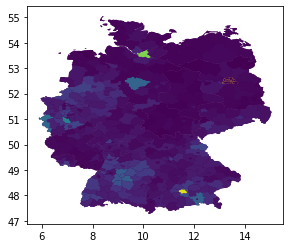

In [4]:
data.plot(column='current')

Judging from the video there is clearly a spatial component to the spread of the virus

In [5]:
# from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots(1, 1)

# def update(i):
#     a = data.plot(column=dateColNames[i], ax=ax)
#     a.set_title(dateColNames[i])

# ani = FuncAnimation(fig, update, range(len(dateColNames)), interval=400, repeat=True)
# ani.save('./output/cases_germany.mp4')

In [6]:
bundeslaender = data[data.art == 'bundesland']
landkreise = data[data.art == 'landkreis']
landkreise[dateColNames] = landkreise[dateColNames].astype(np.int64)
bundeslaender[dateColNames] = landkreise.groupby('partof')[dateColNames].sum()
landkreise.current = landkreise.current.astype(np.int64)
bundeslaender.current = landkreise.groupby('partof').current.sum()

In [7]:
laenderNames = bundeslaender.index
laenderIds = np.arange(len(laenderNames))
bayernCuml = bundeslaender.loc['Bayern']
KBayern = bayernCuml['population']

We will focus only on Bavaria for now, because we have the exact date when the curfew was put into action there (22.03.2020).

In [8]:
landkreiseBayern = landkreise[landkreise.partof == 'Bayern']
landkreisNamesBayern = landkreiseBayern.index
landkreisIdsBayern = np.arange(len(landkreisNamesBayern))
populationBayern = landkreiseBayern['population'].values
KsBayern = landkreiseBayern['population']
T = len(dateColNames)
L = len(landkreisIdsBayern)
time = np.arange(T)
incubationTime = 7
tCurfew = list(dateColNames.values).index('22.03.2020')
tCurfewEffect = tCurfew + incubationTime

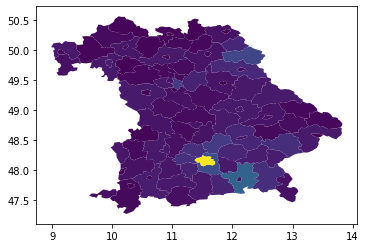

In [9]:
landkreiseBayern.plot(column='current')

### 1. Simple model

As a sanity check, let's first fit an ordinary logistic model to our data.

In [10]:
def simpleModelBayern(alpha):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [11]:
def mseBayern(paras, model):
    y = bayernCuml[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [12]:
resultsSimpleBayern = scpo.minimize(mseBayern, x0=[1.0], bounds=((0.01, 5.0),), args=(simpleModelBayern,))
resultsSimpleBayern

      fun: 18782150.470354203
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.09781933])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 5
   status: 0
  success: True
        x: array([0.19251171])

In [13]:
def plotSim(mod, paras):
    y = bayernCuml[dateColNames].values
    ySim = mod(*paras)
    plt.scatter(time, y)
    plt.plot(time, ySim)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

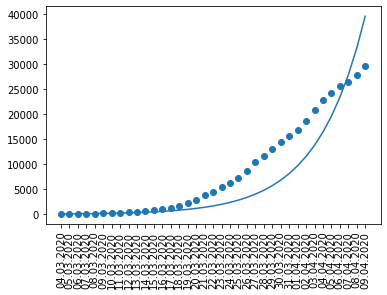

In [14]:
plotSim(simpleModelBayern, (resultsSimpleBayern.x,))

How does this model do at predicting local infections?

In [19]:
def simpleModelLocal(alpha):
    infected = np.zeros((L, T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]]
    for t in range(T-1):
        dndt = alpha * infected[:, t] * (1 - infected[:, t] / KsBayern)
        infected[:, t+1] = infected[:, t] + dndt
    return infected

In [50]:
def mseSpatial(paras, model):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim)**2)
    return me

def mseSpatialRelative(paras, model):
    # mseSpatial might give extra weight to large cities. This method normalizes all errors by population.
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    populationBayernRs = populationBayern.reshape(len(populationBayern), 1)
    y_p = (y / populationBayernRs) * 10000
    y_sim_p = (y_sim / populationBayernRs) * 10000
    me = np.mean((y_p - y_sim_p) ** 2)
    return me

In [51]:
mseSpatialRelative(resultsSimpleBayern.x, simpleModelLocal)

443.7477407769852

In [21]:
def plotSimLks(mod, paras, lkNames):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    for lkName in lkNames:
        i = list(landkreiseBayern.index).index(lkName)
        plt.scatter(time, y[i])
        plt.plot(time, ySim[i], label=lkName)
    plt.legend()
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

In [22]:
def plotSimLksRelative(mod, paras, lkNames):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    for lkName in lkNames:
        i = list(landkreiseBayern.index).index(lkName)
        pop = populationBayern[i]
        plt.scatter(time, 1000 * y[i] / pop)
        plt.plot(time, 1000 * ySim[i] / pop, label=lkName)
    plt.legend()
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

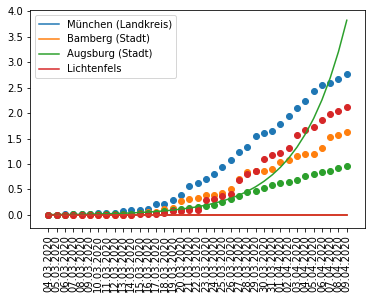

In [24]:
plotSimLksRelative(simpleModelLocal, resultsSimpleBayern.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)',  'Lichtenfels'])

In [25]:
def plotSimLksCuml(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    y_cuml = np.sum(y, axis=0)
    y_sim_cuml = np.sum(y_sim, axis=0)
    plt.scatter(time, y_cuml)
    plt.plot(time, y_sim_cuml)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

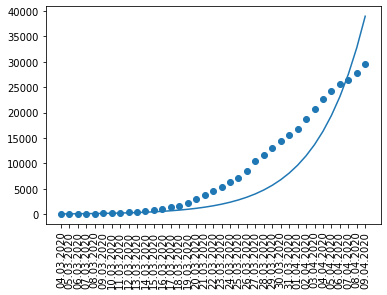

In [26]:
plotSimLksCuml(simpleModelLocal, resultsSimpleBayern.x)

### 2. Allowing step in $\alpha$

In [27]:
def stepModelBayern(alpha0, alpha1):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [28]:
resultsStepBayern = scpo.minimize(mseBayern, x0=[1.0, 1.0], bounds=((0.01, 5.0), (0.01, 5.0)), args=(stepModelBayern,))
resultsStepBayern

      fun: 524695.8277719732
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.3865141 , -0.17462298])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 189
      nit: 21
   status: 0
  success: True
        x: array([0.23779335, 0.06941015])

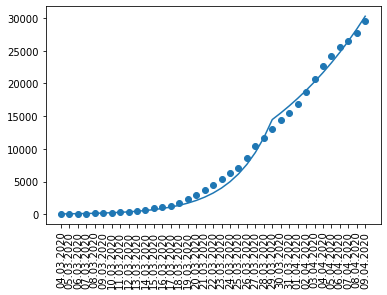

In [29]:
plotSim(stepModelBayern, resultsStepBayern.x)

In [31]:
def stepModelLocal(alpha0, alpha1):
    infected = np.zeros((L, T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]]
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        dndt = alpha * infected[:, t] * (1 - infected[:, t] / KsBayern)
        infected[:, t+1] = infected[:, t] + dndt
    return infected

In [52]:
mseSpatialRelative(resultsStepBayern.x, stepModelLocal)

506.7263437515432

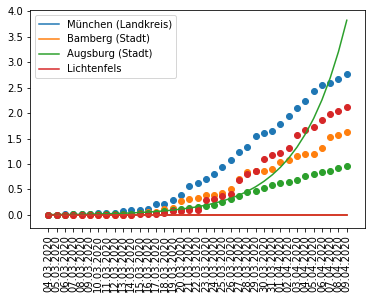

In [33]:
plotSimLksRelative(simpleModelLocal, resultsSimpleBayern.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)',  'Lichtenfels'])

### 3. Spatial model  (with toy-connectivity)

First, we need to calculate $C_{x, y, t}$. 
In the next section we'll use ESA's $NO_x$ data from Sentinel 5P, but as a simple stand-in, let's for now just assume that Landkreise have some connectivity $n$ if they are neighbors of first or second degree.

In [34]:
# Neighbors of 0th degree: every LK is its own 0th order neighbor

L = len(landkreisNamesBayern)
neighbors0th = np.eye(L, dtype=bool)

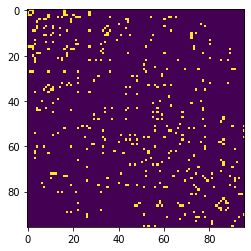

In [35]:
# Neighbors of 1st degree: when they share one border

neighbors1st = np.zeros((L, L), dtype=bool)
for x in range(L):
    for y in range(x, L):
        lkName1 = landkreiseBayern.index[x]
        lkName2 = landkreiseBayern.index[y]
        lk1 = landkreiseBayern.loc[lkName1]
        lk2 = landkreiseBayern.loc[lkName2]
        if lk1.geometry.touches(lk2.geometry):
            neighbors1st[x, y] = True
            neighbors1st[y, x] = True

plt.imshow(neighbors1st)

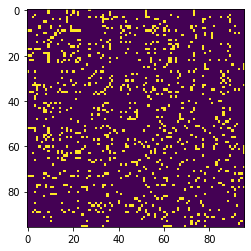

In [36]:
# Neighbors of 2nd degree: when they both touch one other LK

neighbors2nd = neighbors1st.dot(neighbors1st) * ~neighbors1st * ~neighbors0th

plt.imshow(neighbors2nd)

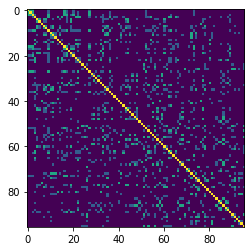

In [37]:
def calcConnectivity(n):
    L = len(landkreisNamesBayern)
    connectivity = np.zeros((L, L), dtype=np.float64)
    for x in range(L):
        for y in range(x, L):
            if neighbors0th[x, y]:
                c = 1
            elif neighbors1st[x, y]:
                c = n
            elif neighbors2nd[x, y]:
                c = n / 2
            else:
                c = 0.0
            connectivity[x, y] = c
            connectivity[y, x] = c
    return connectivity

tc = calcConnectivity(0.6)
plt.imshow(tc)

We can now make use of that connectivity in our model. Remember that $C_{x, y, t}$ is supposed to be time-dependent. In this simplified example, we just assume that $C$ is reduced globally by some factor $m$ once the curfew is implemented. We'll make this more detailed once we work with actual $NO_x$ data.

In [38]:
def spatialModel(alpha0, alpha1, n, m):
    infected = np.zeros((len(landkreisIdsBayern), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    connectivity = calcConnectivity(n)
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        conct = connectivity if t < tCurfew else m * connectivity
        for landkreis in landkreisIdsBayern:
            K = KsBayern[landkreis]
            nc = np.inner( conct[landkreis, :], infected[:, t] )
            dndt = alpha * nc * (1 - infected[landkreis, t] / K)
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

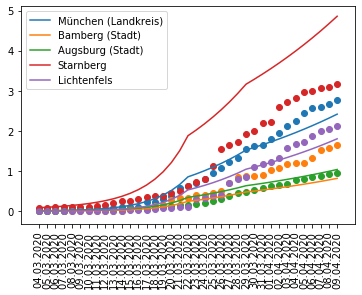

In [58]:
# Doing a testplot to find a good starting point
startParas = [0.1, 0.05, 0.18, 0.3]
plotSimLksRelative(spatialModel, startParas, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

In [53]:
def wrapHistory(objectiveFunction, history):
    def wrapped(*args):
        v = objectiveFunction(*args)
        history.append({'args': args, 'val': v})
        return v
    return wrapped

In [59]:
historySpatial = []
resultsSpatial = scpo.minimize(wrapHistory(mseSpatialRelative, historySpatial), x0=startParas, bounds=((0.001, .5), (0.001, .5), (0.001, 0.3), (0.01, 0.99)), args=(spatialModel,))
resultsSpatial

      fun: 62.73173404453884
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.61888338e-04, -3.74669185e-03, -1.82912530e+00, -1.60582658e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 355
      nit: 55
   status: 0
  success: True
        x: array([0.05122495, 0.02014029, 0.3       , 0.8492187 ])

In [55]:
def scatterHistory(hist, p1, p2, filterFunc, l1, l2, cmapName='viridis'):
    xs = []
    ys = []
    zs = []
    for e in hist:
        if filterFunc(e):
            xs.append(e['args'][0][p1])
            ys.append(e['args'][0][p2])
            zs.append(e['val'])
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    img = ax.scatter(xs, ys, c=zs, cmap=plt.get_cmap(cmapName))
    ax.set_xlabel(l1)
    ax.set_ylabel(l2)
    legend1 = ax.legend(*img.legend_elements(),
                    loc="lower left")
    ax.add_artist(legend1)


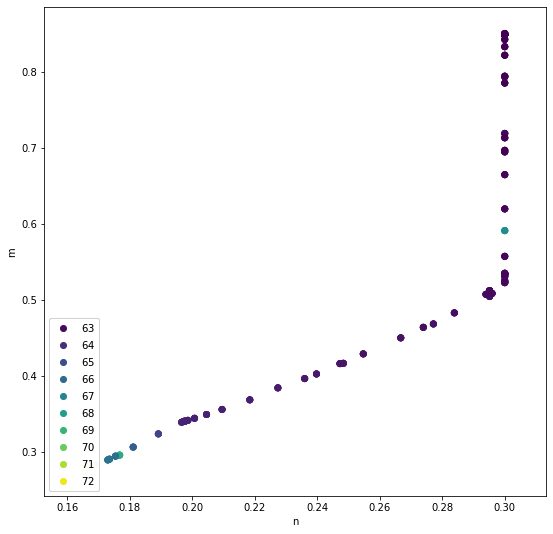

In [60]:
scatterHistory(historySpatial, 2, 3, lambda e: e['val'] < 80, 'n', 'm')

Let's look at how this model does for some Landkreise and globally.

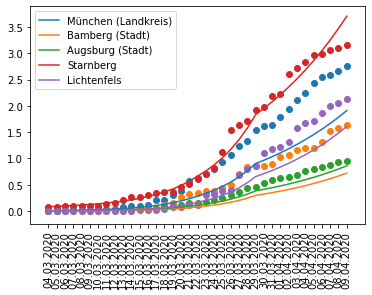

In [61]:
plotSimLksRelative(spatialModel, resultsSpatial.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

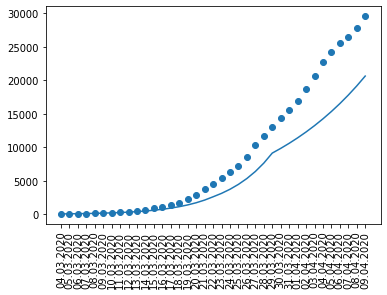

In [62]:
plotSimLksCuml(spatialModel, resultsSpatial.x)

### 4. Spatial model (with actual $NO_x$ data)

We can assume that connectivity within a Landkreis - that is, $C_{x, x, t}$ - is proportional to the $NO_x$ within the bounds of that Landkreis.

It might make sense to assume the connectivity between Landkreise - $C_{x, y, t}, x \neq y$ - is proportional to the $NO_x$ between the center of one Landkreis and the center of another. But that would unintentionally include the traffic from the edges of a Landkreis to the center.

Instead, we'll overlay the borders of Landkreise with the routes of highways. These intersections are the points where traffic is going from one Landkreis to another. 

In [63]:
lksNo2 = gpd.read_file("./data/landkreise_no2_14d.json", driver="GeoJSON")
lksNo2 = lksNo2.set_index('name')

In [65]:
lksNo2.head(1)

art          partof  population    AGS  beforeCuml  afterCuml  \
name                                                                         
Halle  landkreis  Sachsen-Anhalt      239257  15002    0.000249     0.0002   

       observationCount    before   after  beforeNormal  afterNormal  \
name                                                                   
Halle               2.0  0.000125  0.0001      0.007363     0.005917   

       NO2_traffic_before  NO2_non_traffic  NO2_traffic_after  NO2_diff  \
name                                                                      
Halle            0.000062         0.000062           0.000038 -0.000024   

       NO2_diff_frac                                           geometry  
name                                                                     
Halle       0.607299  POLYGON ((12.00471 51.53966, 12.04427 51.49398...

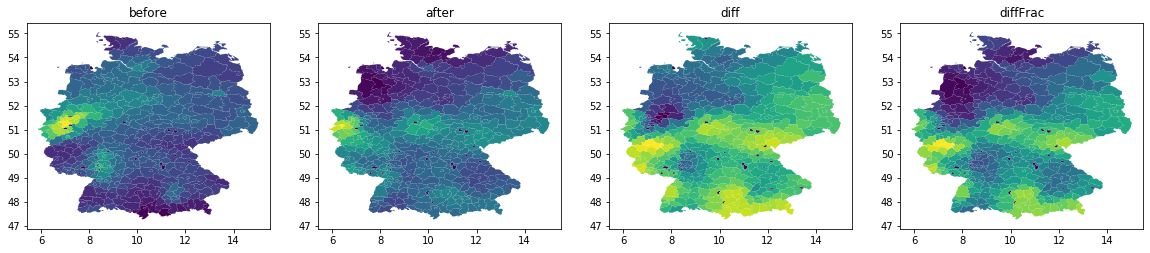

In [66]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
vmax = lksNo2['beforeNormal'].max()
axes[0].vmax = vmax
axes[1].vmax = vmax
axes[2].vmax = vmax
axes[3].vmax = vmax
axes[0].set_title('before')
axes[1].set_title('after')
axes[2].set_title('diff')
axes[3].set_title('diffFrac')
lksNo2.plot(column='NO2_traffic_before', axes=axes[0])
lksNo2.plot(column='NO2_traffic_after', axes=axes[1])
lksNo2.plot(column='NO2_diff', axes=axes[2])
lksNo2.plot(column='NO2_diff_frac', axes=axes[3])

As a sanity check, compare the emission map of Germany with the NO2 map published [here](https://unearthed.greenpeace.org/2018/10/29/nitrogen-dioxide-no2-pollution-world-map/) and [here](https://www.independent.co.uk/environment/satellite-images-emissions-climate-crisis-coronavirus-europe-map-a9426436.html)

In [67]:
def calcReducedConnectivity(connectivity):
    connectivityReduced = np.copy(connectivity)
    X, Y = connectivity.shape
    for x in range(X):
        for y in range(x, Y):
            c = connectivity[x, y]
            if connectivity[x, y] > 0:
                reduction1 = lksNo2.loc[landkreiseBayern.index[x], 'NO2_diff_frac']
                reduction2 = lksNo2.loc[landkreiseBayern.index[y], 'NO2_diff_frac']
                if not np.isnan(reduction1) and not np.isnan(reduction2):
                    c = c * (reduction1 + reduction2) / 2.0
            connectivityReduced[x, y] = c
            connectivityReduced[y, x] = c
    return connectivityReduced

con = calcConnectivity(0.2)
rcon = calcReducedConnectivity(con)
rcon

array([[0.6096834 , 0.2       , 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 1.        , 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 0.2       , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.73394918, 0.08184993,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08184993, 0.90304946,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.55342795]])

In [68]:
def spatialModelNO2(alpha0, alpha1, n):
    infected = np.zeros((len(landkreisIdsBayern), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    connectivity = calcConnectivity(n)
    connectivityReduced = calcReducedConnectivity(connectivity)
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        conct = connectivity if t < tCurfew else connectivityReduced
        for landkreis in landkreisIdsBayern:
            K = KsBayern[landkreis]
            nc = np.inner( conct[landkreis, :], infected[:, t] )
            dndt = alpha * nc * (1 - infected[landkreis, t] / K)
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

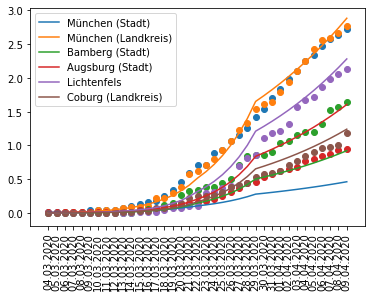

In [72]:
startParasNO2 = [0.07, 0.02, 0.25]
plotSimLksRelative(spatialModelNO2, startParasNO2, ['München (Stadt)', 'München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Lichtenfels', 'Coburg (Landkreis)'])

In [74]:
historyNO2 = []
resultsSpatialNO2 = scpo.minimize(wrapHistory(mseSpatialRelative, historyNO2), x0=startParasNO2, bounds=((0.001, 0.3), (0.001, 0.3), (0.001, 0.6)), args=(spatialModelNO2,))
resultsSpatialNO2

      fun: 63.10901447452664
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00883205,  0.00422915, -1.07074598])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 51
   status: 0
  success: True
        x: array([0.03019885, 0.01279622, 0.6       ])

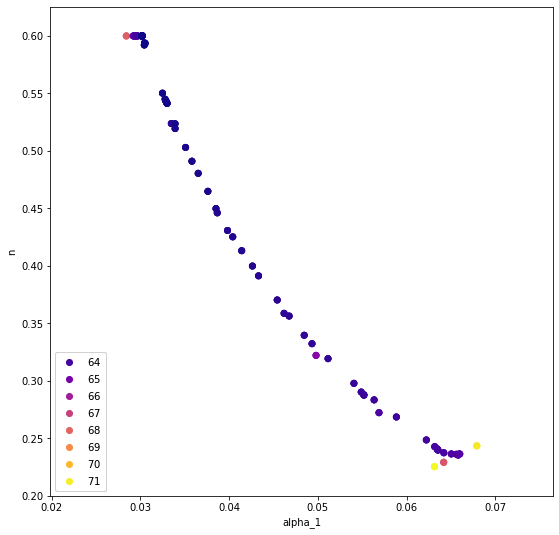

In [75]:
scatterHistory(historyNO2, 0, 2, lambda e: e['val'] < 74.7, "alpha_1", 'n', 'plasma')

Let's see how well the model does for global and local predictions:

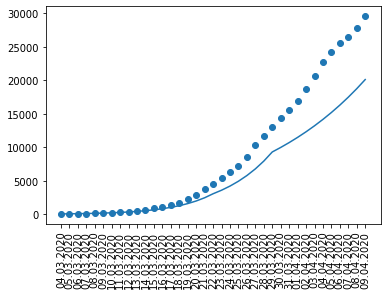

In [76]:
plotSimLksCuml(spatialModelNO2, resultsSpatialNO2.x)

In [77]:
def plotLocalDifferences(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(y)
    axes[0].set_title('data')
    axes[1].imshow((y - y_sim)**2)
    axes[1].set_title('SE')
    axes[2].imshow(y_sim)
    axes[2].set_title('simulation')

def plotLocalDifferencesRelative(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    populationBayernRs = populationBayern.reshape(len(populationBayern), 1)
    y_p = (y / populationBayernRs) * 10000
    y_sim_p = (y_sim / populationBayernRs) * 10000
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(y_p)
    axes[0].set_title('data')
    axes[1].imshow((y_p - y_sim_p)**2)
    axes[1].set_title('SE')
    axes[2].imshow(y_sim_p)
    axes[2].set_title('simulation')

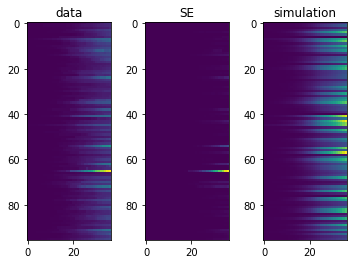

In [78]:
plotLocalDifferencesRelative(spatialModelNO2, resultsSpatialNO2.x)

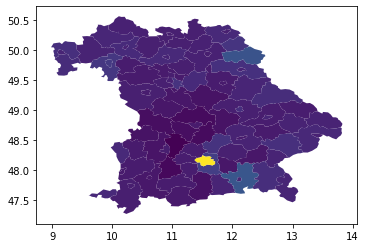

In [79]:
def differenceMap(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    lksBdiff = landkreiseBayern.copy()
    lksBdiff['diffSim'] = np.sum(y - y_sim, axis=1)
    lksBdiff.plot(column='diffSim')

differenceMap(spatialModelNO2, resultsSpatialNO2.x)

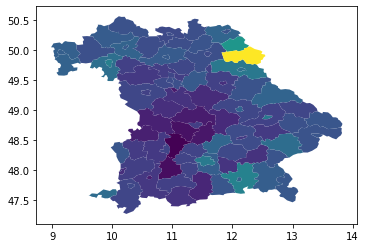

In [80]:
def differenceMapRelative(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    lksBdiff = landkreiseBayern.copy()
    lksBdiff['diffSim'] = np.sum(y - y_sim, axis=1)
    lksBdiff['diffSimRel'] = lksBdiff['diffSim'] / lksBdiff['population']
    lksBdiff.plot(column='diffSimRel')

differenceMapRelative(spatialModelNO2, resultsSpatialNO2.x)

Text(0, 0.5, 'error')

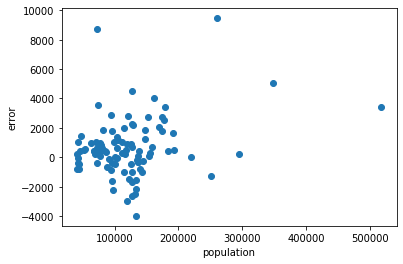

In [82]:
y = landkreiseBayern[dateColNames].values
y_sim = spatialModelNO2(*(resultsSpatialNO2.x))

iMunich = list(landkreisNamesBayern).index('München (Stadt)')

err = np.sum((y - y_sim), axis=1)
errCleaned = np.delete(err, [iMunich])
popCleaned = np.delete(populationBayern, [iMunich])

plt.scatter(popCleaned, errCleaned)
plt.xlabel('population')
plt.ylabel('error')

The biggest error is made in the city of Munich, where we underestimate the real values by quite some margin:

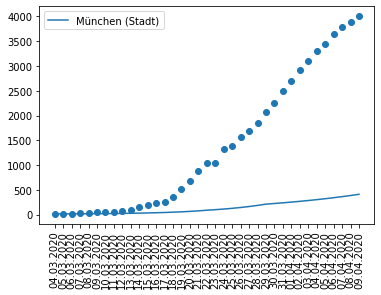

In [83]:
y = landkreiseBayern[dateColNames].values
y_sim = spatialModelNO2(*(resultsSpatialNO2.x))
populationBayernRs = populationBayern.reshape(len(populationBayern), 1)
y_p = (y / populationBayernRs) * 10000
y_sim_p = (y_sim / populationBayernRs) * 10000
sums = np.sum(y - y_sim, axis=1)
mx = np.max(sums)
i = list(sums).index(mx)
lkName = landkreisNamesBayern[i]
plotSimLks(spatialModelNO2, resultsSpatialNO2.x, [lkName])

Let's look at some other places

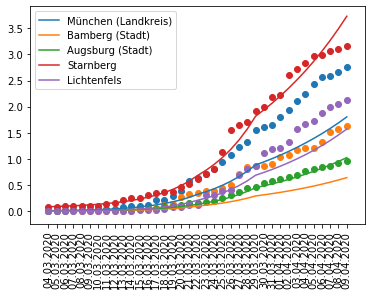

In [84]:
plotSimLksRelative(spatialModelNO2, resultsSpatialNO2.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

Here are the predictions for the biggest cities in Bavaria.

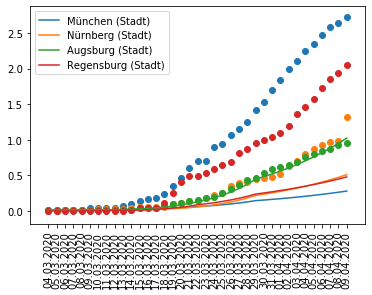

In [85]:
plotSimLksRelative(spatialModelNO2, resultsSpatialNO2.x, ['München (Stadt)', 'Nürnberg (Stadt)', 'Augsburg (Stadt)', 'Regensburg (Stadt)'])

Let's consider some smaller towns instead:

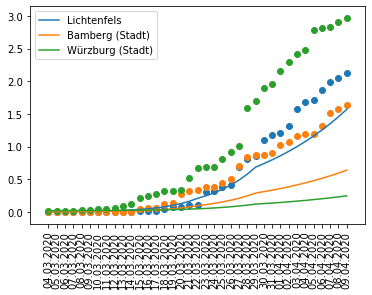

In [86]:
plotSimLksRelative(spatialModelNO2, resultsSpatialNO2.x, ['Lichtenfels', 'Bamberg (Stadt)', 'Würzburg (Stadt)'])